In [1]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.10.8 | packaged by conda-forge | (main, Nov  4 2022, 13:42:51) [MSC v.1916 64 bit (AMD64)]


D:\newapp\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.0


In [2]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [4]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [5]:
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:06<00:00, 4175320.13it/s]


Extracting ./FashionMNIST/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 149748.19it/s]


Extracting ./FashionMNIST/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2587484.87it/s]


Extracting ./FashionMNIST/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 6503697.89it/s]

Extracting ./FashionMNIST/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



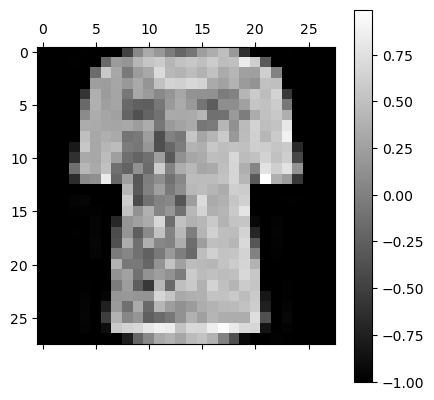

In [6]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

In [7]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [8]:
# STEP 1: Discriminator optimization step
x_real, _ = iter(dataloader).__next__()
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

In [9]:
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.501221239566803


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.001)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.001)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

all_losses_D = []
all_losses_G = []
for epoch in range(10):  # 3 epochs
    size = 0
    current_loss = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).__next__()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)
        lossD = lossD_real + lossD_fake

        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            # show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))

    all_losses_D.append(lossD.cpu().detach().numpy())
    all_losses_G.append(lossG.cpu().detach().numpy())
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

Device:  cuda
e0.i0/938 last mb D(x)=0.4205 D(G(z))=0.4940
e0.i100/938 last mb D(x)=0.9481 D(G(z))=0.3527
e0.i200/938 last mb D(x)=0.9683 D(G(z))=0.1448
e0.i300/938 last mb D(x)=0.9449 D(G(z))=0.0666
e0.i400/938 last mb D(x)=0.9373 D(G(z))=0.0660
e0.i500/938 last mb D(x)=0.9798 D(G(z))=0.0152
e0.i600/938 last mb D(x)=0.7685 D(G(z))=0.2966
e0.i700/938 last mb D(x)=0.8613 D(G(z))=0.1692
e0.i800/938 last mb D(x)=0.9298 D(G(z))=0.0968
e0.i900/938 last mb D(x)=0.6503 D(G(z))=0.2896
e1.i0/938 last mb D(x)=0.8512 D(G(z))=0.1670
e1.i100/938 last mb D(x)=0.4762 D(G(z))=0.2585
e1.i200/938 last mb D(x)=0.8166 D(G(z))=0.2178
e1.i300/938 last mb D(x)=0.8738 D(G(z))=0.0944
e1.i400/938 last mb D(x)=0.8459 D(G(z))=0.1759
e1.i500/938 last mb D(x)=0.9551 D(G(z))=0.0339
e1.i600/938 last mb D(x)=0.6905 D(G(z))=0.2824
e1.i700/938 last mb D(x)=0.7677 D(G(z))=0.2976
e1.i800/938 last mb D(x)=0.7743 D(G(z))=0.2611
e1.i900/938 last mb D(x)=0.4981 D(G(z))=0.4721
e2.i0/938 last mb D(x)=0.6600 D(G(z))=0.4003
e2.i1

<Figure size 640x480 with 0 Axes>

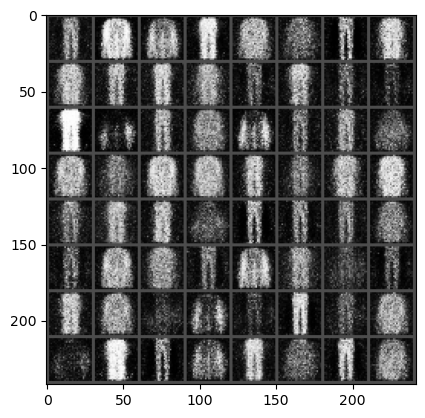

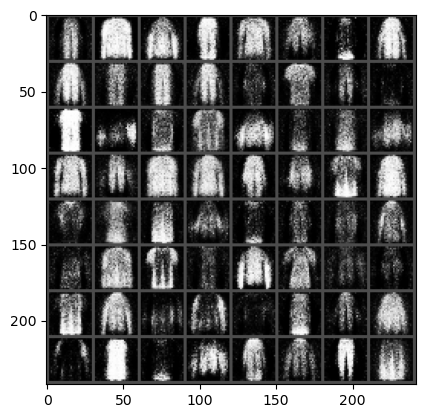

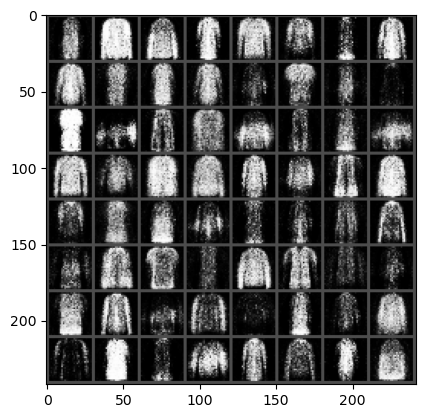

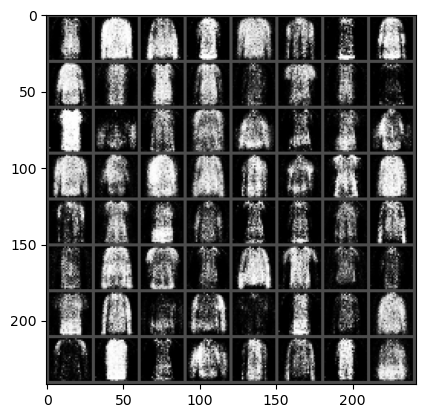

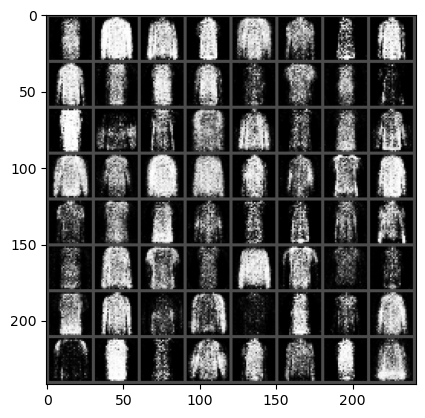

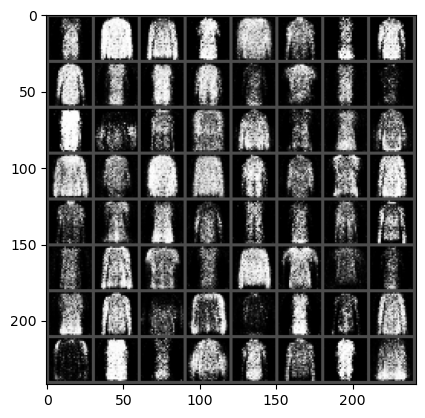

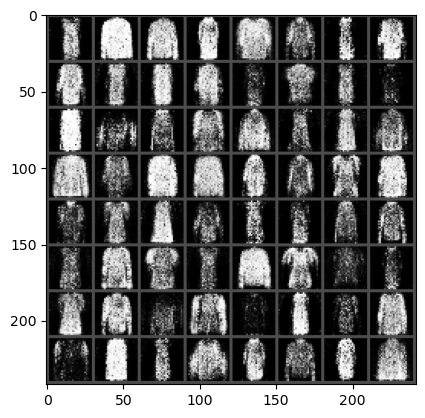

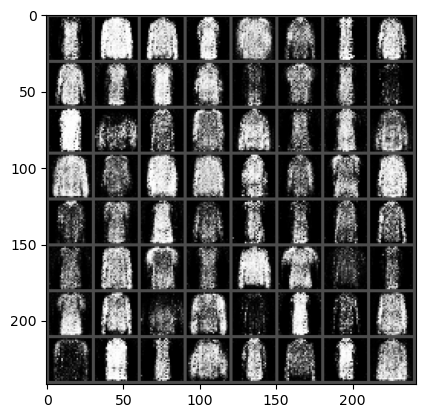

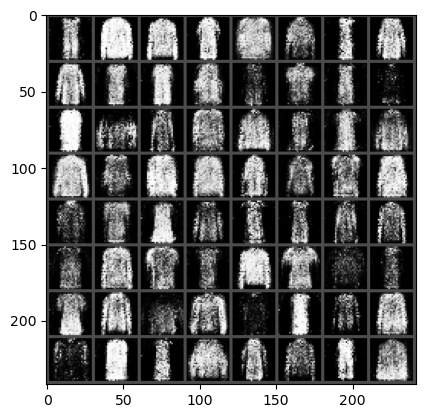

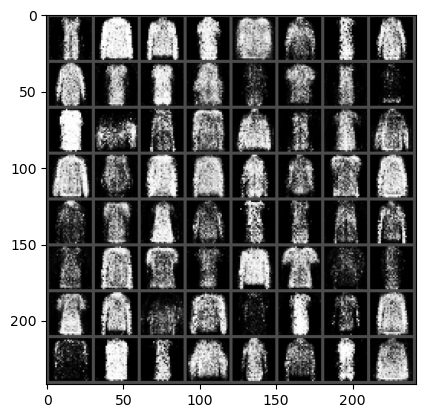

In [11]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

In [12]:
import numpy as np

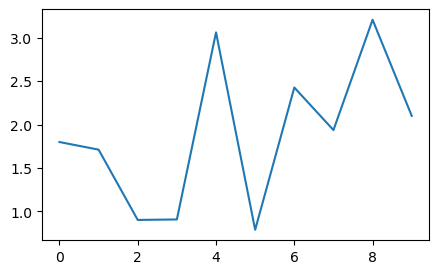

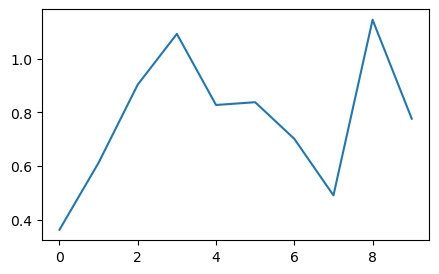

In [13]:
plt.figure(figsize=(5, 3))
plt.plot(all_losses_G)
plt.savefig('lossG')

plt.figure(figsize=(5, 3))
plt.plot(all_losses_D)
plt.savefig('lossV')

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
# optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
# optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

all_losses_D = []
all_losses_G = []
for epoch in range(3):  # 3 epochs
    size = 0
    current_loss = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).__next__()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)
        lossD = lossD_real + lossD_fake

        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            # show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))

    all_losses_D.append(lossD.cpu().detach().numpy())
    all_losses_G.append(lossG.cpu().detach().numpy())
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

Device:  cuda
e0.i0/938 last mb D(x)=0.5359 D(G(z))=0.4603
e0.i100/938 last mb D(x)=0.9914 D(G(z))=0.0281
e0.i200/938 last mb D(x)=0.7498 D(G(z))=0.0897
e0.i300/938 last mb D(x)=0.7537 D(G(z))=0.2321
e0.i400/938 last mb D(x)=0.8906 D(G(z))=0.0925
e0.i500/938 last mb D(x)=0.9851 D(G(z))=0.0253
e0.i600/938 last mb D(x)=0.9719 D(G(z))=0.0589
e0.i700/938 last mb D(x)=0.9315 D(G(z))=0.0370
e0.i800/938 last mb D(x)=0.8781 D(G(z))=0.1087
e0.i900/938 last mb D(x)=0.9012 D(G(z))=0.0690
e1.i0/938 last mb D(x)=0.8434 D(G(z))=0.0653
e1.i100/938 last mb D(x)=0.9203 D(G(z))=0.0698
e1.i200/938 last mb D(x)=0.8275 D(G(z))=0.0932
e1.i300/938 last mb D(x)=0.8412 D(G(z))=0.1236
e1.i400/938 last mb D(x)=0.8125 D(G(z))=0.0836
e1.i500/938 last mb D(x)=0.9370 D(G(z))=0.0571
e1.i600/938 last mb D(x)=0.8366 D(G(z))=0.1297
e1.i700/938 last mb D(x)=0.9376 D(G(z))=0.1449
e1.i800/938 last mb D(x)=0.9691 D(G(z))=0.0627
e1.i900/938 last mb D(x)=0.9233 D(G(z))=0.0885
e2.i0/938 last mb D(x)=0.9333 D(G(z))=0.0523
e2.i1

<Figure size 640x480 with 0 Axes>

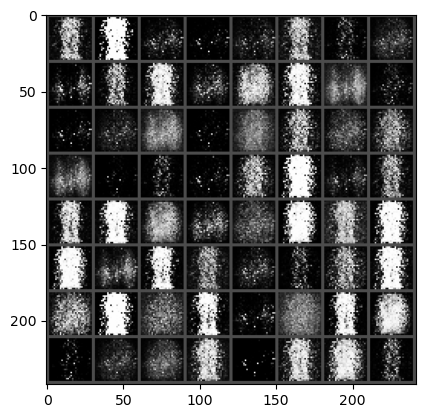

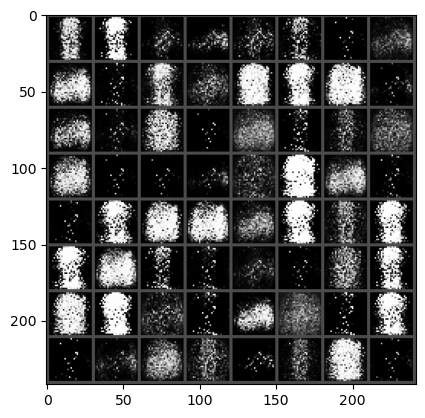

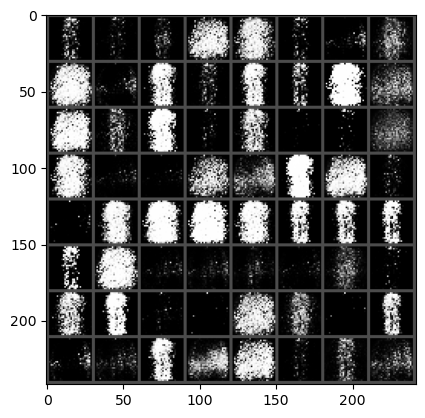

In [15]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

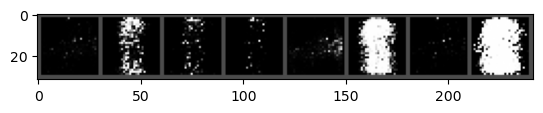

In [16]:
random_noise = torch.randn(8, 100, device=device)
x_gen = G(random_noise)
show_imgs(x_gen, new_fig=False)

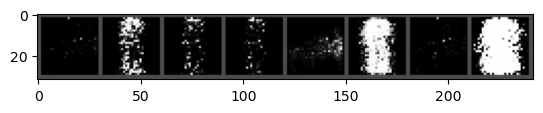

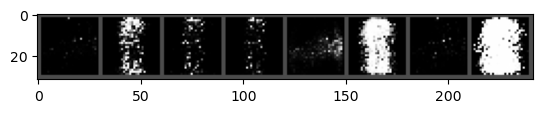

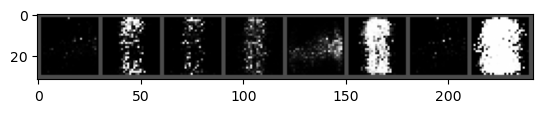

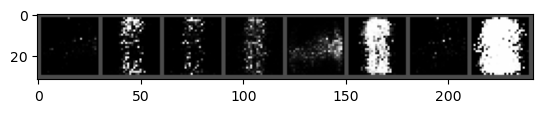

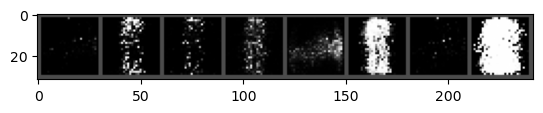

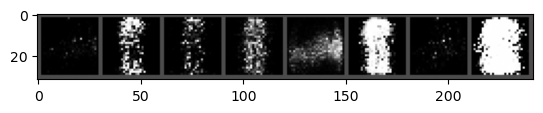

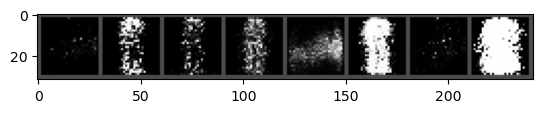

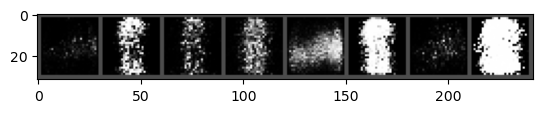

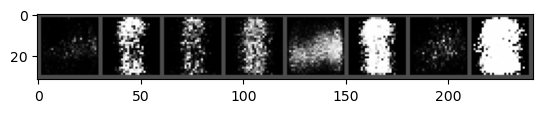

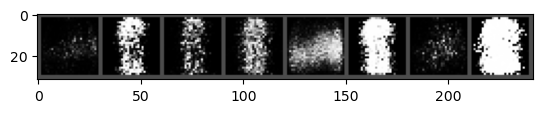

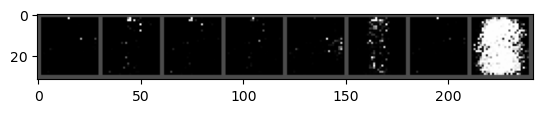

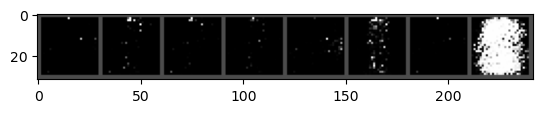

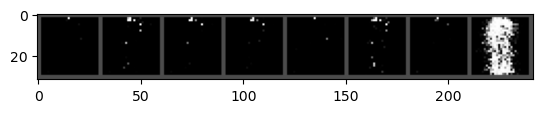

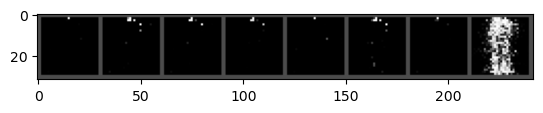

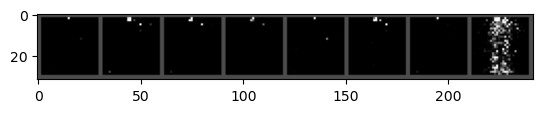

In [17]:
random_list = [0.1,1,-5]
for cnt in range(3):
    for random_num in range(5):
        for _ in random_noise:
            _[random_num] = random_list[cnt]
        x_gen = G(random_noise)
        show_imgs(x_gen, new_fig=True)

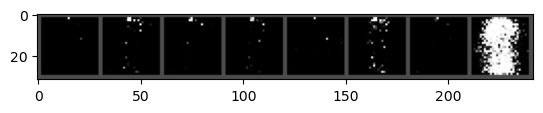

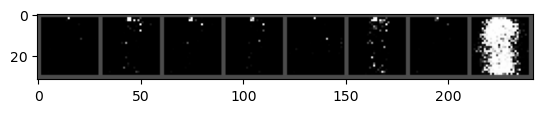

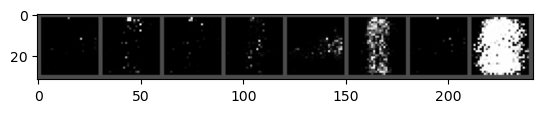

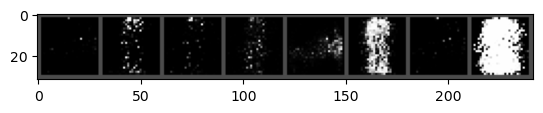

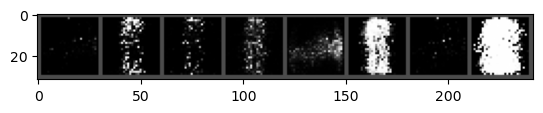

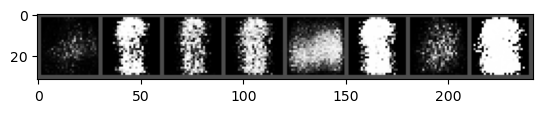

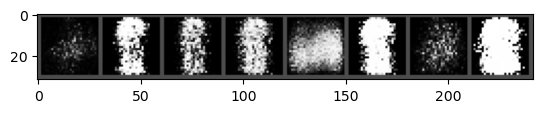

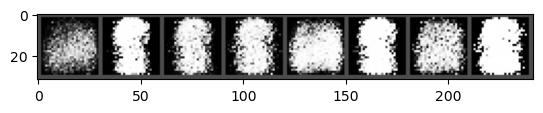

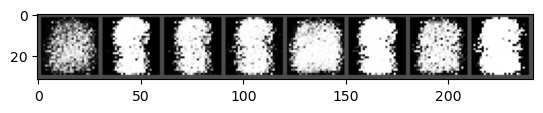

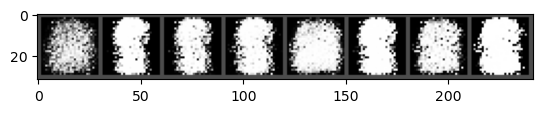

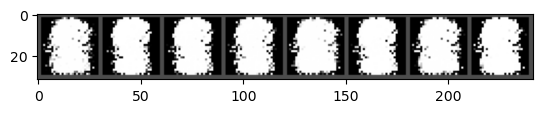

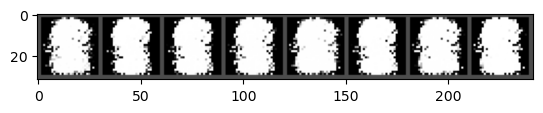

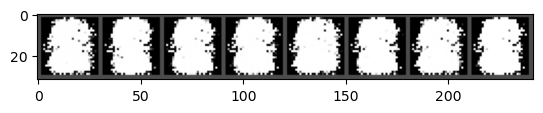

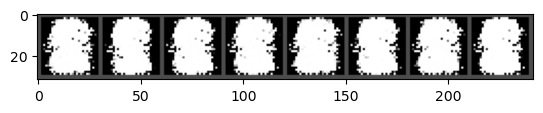

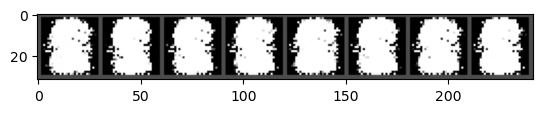

In [18]:
random_list = [0.1,3,10]
for cnt in range(3):
    for random_num in range(5):
        for _ in random_noise:
            _[random_num] = random_list[cnt]
        x_gen = G(random_noise)
        show_imgs(x_gen, new_fig=True)

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 32 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 32 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
print(D)
print(G)

Device:  cuda
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
 

In [21]:
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.001)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.001)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

all_losses_D = []
all_losses_G = []
for epoch in range(10):  # 3 epochs
    size = 0
    current_loss = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).__next__()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)
        lossD = lossD_real + lossD_fake

        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            # show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))

    all_losses_D.append(lossD.cpu().detach().numpy())
    all_losses_G.append(lossG.cpu().detach().numpy())
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

e0.i0/938 last mb D(x)=0.5099 D(G(z))=0.5106
e0.i100/938 last mb D(x)=0.5875 D(G(z))=0.4849
e0.i200/938 last mb D(x)=0.5717 D(G(z))=0.4484
e0.i300/938 last mb D(x)=0.9389 D(G(z))=0.1083
e0.i400/938 last mb D(x)=0.9904 D(G(z))=0.0236
e0.i500/938 last mb D(x)=0.9969 D(G(z))=0.0105
e0.i600/938 last mb D(x)=0.9956 D(G(z))=0.0078
e0.i700/938 last mb D(x)=0.9988 D(G(z))=0.0086
e0.i800/938 last mb D(x)=0.9985 D(G(z))=0.0050
e0.i900/938 last mb D(x)=0.9975 D(G(z))=0.0033
e1.i0/938 last mb D(x)=0.9985 D(G(z))=0.0022
e1.i100/938 last mb D(x)=0.9994 D(G(z))=0.0036
e1.i200/938 last mb D(x)=0.9990 D(G(z))=0.0020
e1.i300/938 last mb D(x)=0.9996 D(G(z))=0.0016
e1.i400/938 last mb D(x)=0.9989 D(G(z))=0.0021
e1.i500/938 last mb D(x)=0.9990 D(G(z))=0.0010
e1.i600/938 last mb D(x)=0.9994 D(G(z))=0.0012
e1.i700/938 last mb D(x)=0.9994 D(G(z))=0.0013
e1.i800/938 last mb D(x)=0.9996 D(G(z))=0.0011
e1.i900/938 last mb D(x)=0.9996 D(G(z))=0.0008
e2.i0/938 last mb D(x)=0.9993 D(G(z))=0.0009
e2.i100/938 last mb

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
from torch.autograd import Variable
adversarial_loss = torch.nn.BCELoss()
cuda = True if torch.cuda.is_available() else False
if cuda:
    G.cuda()
    D.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.01, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.01, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
for epoch in range(5):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],100))))

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i%100==0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, 5, i, len(dataloader), d_loss.item(), g_loss.item())
            )

[Epoch 0/5] [Batch 0/938] [D loss: 0.000046] [G loss: 10.749343]
[Epoch 0/5] [Batch 100/938] [D loss: 0.000004] [G loss: 17.419029]
[Epoch 0/5] [Batch 200/938] [D loss: 0.000001] [G loss: 18.478985]
[Epoch 0/5] [Batch 300/938] [D loss: 0.000000] [G loss: 19.585062]
[Epoch 0/5] [Batch 400/938] [D loss: 0.000000] [G loss: 19.271460]
[Epoch 0/5] [Batch 500/938] [D loss: 0.000000] [G loss: 19.663458]
[Epoch 0/5] [Batch 600/938] [D loss: 0.000000] [G loss: 20.122948]
[Epoch 0/5] [Batch 700/938] [D loss: 0.000000] [G loss: 19.644447]
[Epoch 0/5] [Batch 800/938] [D loss: 0.000000] [G loss: 20.002106]
[Epoch 0/5] [Batch 900/938] [D loss: 0.000001] [G loss: 20.990282]
[Epoch 1/5] [Batch 0/938] [D loss: 0.000001] [G loss: 20.851948]
[Epoch 1/5] [Batch 100/938] [D loss: 0.000000] [G loss: 20.949287]
[Epoch 1/5] [Batch 200/938] [D loss: 0.000000] [G loss: 20.882053]
[Epoch 1/5] [Batch 300/938] [D loss: 0.000000] [G loss: 20.517401]
[Epoch 1/5] [Batch 400/938] [D loss: 0.000000] [G loss: 20.482052]

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(all_losses_G)
plt.savefig('lossG')

plt.figure(figsize=(5, 3))
plt.plot(all_losses_D)
plt.savefig('lossV')

In [ ]:
random_noise = torch.randn(8, 100, device=device)
x_gen = G(random_noise)
show_imgs(x_gen, new_fig=False)

In [ ]:
u